In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
from collections import defaultdict
import re

def read_file(path):
    with open(path, encoding = "ISO-8859-1") as f:
        content = np.array(f.readlines())
    return content

def get_vocab(content):
    # Builds a dict with word counts
    # counts number of times a word is on a document
    vocab = defaultdict(float)
    for line in content:
        words = set(line.split())
        for word in words:
            vocab[word] += 1
    return vocab

In [3]:
PATH = './data/'
sub_content = read_file(PATH + "quote.tok.gt9.5000")
obj_content = read_file(PATH + "plot.tok.gt9.5000")
sub_content = np.array([line.strip().lower() for line in sub_content])
obj_content = np.array([line.strip().lower() for line in obj_content])
sub_y = np.zeros(len(sub_content))
obj_y = np.ones(len(obj_content))
X = np.append(sub_content, obj_content)
y = np.append(sub_y, obj_y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [5]:
data_vocab = get_vocab(X_train)

In [6]:
def load_glove_embeddings(gloveFile=PATH + "glove.6B.300d.txt"):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

word_vecs = load_glove_embeddings()

In [7]:
print(len(word_vecs.keys()), len(data_vocab.keys()))

400000 21415


In [8]:
def delete_rare_words(word_vecs, data_vocab, min_df=2):
    """ Deletes rare words from data_vocab
    
    Deletes words from data_vocab if they are not in word_vecs
    and don't have at least min_df occurrencies in data_vocab.
    """
    words_delete = []
    for word in data_vocab:
        if data_vocab[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    for word in words_delete: data_vocab.pop(word)
    return data_vocab

print(len(data_vocab.keys()))
data_vocab = delete_rare_words(word_vecs, data_vocab, min_df=2)
len(data_vocab.keys())

21415


18756

In [13]:
def create_embedding_matrix(word_vecs, data_vocab, min_df=2, D=300):
    # Creates embedding matrix from word vectors
    # because we need to put the pretrained weights into a proper format
    # as an input for the model
    data_vocab = delete_rare_words(word_vecs, data_vocab, min_df)
    V = len(data_vocab.keys()) + 2
    vocab2index = {}
    W = np.zeros((V,D), dtype="float32")
    vocab = ["", "UNK"]
    # adding a vector for padding
    W[0] = np.zeros(D, dtype='float32')
    # adding a vector for rare words
    W[1] = np.random.uniform(-0.25,0.25,D)
    vocab2index["UNK"] = 1
    i = 2
    for word in data_vocab:
        if word in word_vecs:
            W[i] = word_vecs[word]
            vocab2index[word] = i
            vocab.append(word)
            i += 1
        else:
            W[i] = np.random.uniform(-0.25,0.25,D)
            vocab2index[word] = i
            vocab.append(word)
            i += 1
    return W, np.array(vocab), vocab2index

pretrained_weight, vocab, vocab2index = create_embedding_matrix(word_vecs, data_vocab)

In [14]:
len(pretrained_weight)

18758

In [22]:
def encode_sentence(s, N=40):
    enc = np.zeros(N, dtype=np.int32)
    enc1 = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s.split()])
    l = min(N, len(enc1))
    enc[:l] = enc1[:l]
    return enc

x_train = np.vstack([encode_sentence(x) for x in X_train])
x_val = np.vstack([encode_sentence(x) for x in X_val])
x_test = np.vstack([encode_sentence(x) for x in X_test])

In [23]:
encode_sentence(X_train[0])

array([ 9, 11,  7,  3,  8,  4,  2,  3, 10,  6,  5, 12,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)

In [24]:
"""
V = vocabulary size
D = embedding size
N = max sentence length
"""
class SentenceCNN(nn.Module):    
    def __init__(self, V, D, glove_weights):
        super(SentenceCNN, self).__init__()
        self.glove_weights = glove_weights
        self.embedding = nn.Embedding(V, D, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(self.glove_weights))
        self.embedding.weight.requires_grad = False ## freeze embeddings

        self.conv_3 = nn.Conv1d(in_channels=D, out_channels=100, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=D, out_channels=100, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=D, out_channels=100, kernel_size=5)
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1,2)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        x3 = nn.MaxPool1d(kernel_size = 38)(x3)
        x4 = nn.MaxPool1d(kernel_size = 37)(x4)
        x5 = nn.MaxPool1d(kernel_size = 36)(x5)
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        return self.fc(out)   

In [25]:
V = len(pretrained_weight)
D = 300
N = 40
model = SentenceCNN(V, D, glove_weights=pretrained_weight)

In [26]:
def evaluate(model, x, y):
    model.eval()
    y_hat = model(x)
    loss = F.binary_cross_entropy_with_logits(y_hat, y)
    y_pred = y_hat > 0
    correct = (y_pred.float() == y).float().sum()
    accuracy = correct/y_pred.shape[0]
    return {'loss': loss.item(), 'accuracy': accuracy.item()}    

In [27]:
def plot_accuracies(history):
    accuracies = [x['accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [28]:
# accuracy of a random model should be around 0.5
x_test = torch.LongTensor(x_test) #.cuda()
x_val = torch.LongTensor(x_val)
y_test = torch.Tensor(y_test).unsqueeze(1) #).cuda()
y_val = torch.Tensor(y_val).unsqueeze(1) #).cuda()

In [30]:
evaluate(model, x_val, y_val)

{'loss': 0.6980594396591187, 'accuracy': 0.4580000042915344}

In [34]:
def train_epochs(model, epochs=10, lr=0.01):
    metrics = []
    parameters = filter(lambda p: p.requires_grad, model.parameters()) #filters parameters with p.requires_grad=True
    optimizer = torch.optim.Adam(parameters, lr=lr)
    model.train()
    for i in range(epochs):
        model.train()
        x = torch.LongTensor(x_train)  #.cuda()
        y = torch.Tensor(y_train).unsqueeze(1)
        y_hat = model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ev = evaluate(model, x, y)
        metrics.append(ev)
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(i, ev['loss'], ev['accuracy']))
    return metrics

Epoch [0], train_loss: 0.7312, train_acc: 0.6706
Epoch [1], train_loss: 0.2876, train_acc: 0.8815
Epoch [2], train_loss: 0.3403, train_acc: 0.8595
Epoch [3], train_loss: 0.4545, train_acc: 0.8043
Epoch [4], train_loss: 0.3902, train_acc: 0.8356
Epoch [5], train_loss: 0.3005, train_acc: 0.8850
Epoch [6], train_loss: 0.2664, train_acc: 0.9071
Epoch [7], train_loss: 0.2824, train_acc: 0.8965
Epoch [8], train_loss: 0.3123, train_acc: 0.8739
Epoch [9], train_loss: 0.3230, train_acc: 0.8650
validation set: {'loss': 0.3857586681842804, 'accuracy': 0.8199999928474426}


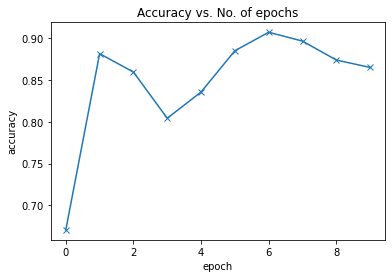

In [35]:
metrics = train_epochs(model, epochs=10, lr=0.005)
print('validation set:', evaluate(model, x_val, y_val))
plot_accuracies(metrics)

Epoch [0], train_loss: 0.2765, train_acc: 0.8971
Epoch [1], train_loss: 0.2551, train_acc: 0.9129
Epoch [2], train_loss: 0.2496, train_acc: 0.9146
Epoch [3], train_loss: 0.2496, train_acc: 0.9118
Epoch [4], train_loss: 0.2484, train_acc: 0.9099
Epoch [5], train_loss: 0.2427, train_acc: 0.9114
Epoch [6], train_loss: 0.2327, train_acc: 0.9133
Epoch [7], train_loss: 0.2208, train_acc: 0.9170
Epoch [8], train_loss: 0.2102, train_acc: 0.9209
Epoch [9], train_loss: 0.2033, train_acc: 0.9236
validation set: {'loss': 0.25566279888153076, 'accuracy': 0.8949999809265137}


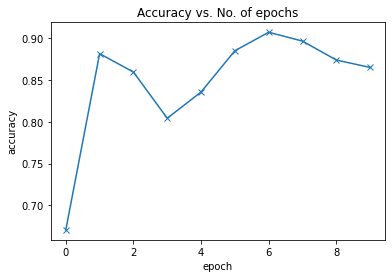

In [36]:
train_epochs(model, epochs=10, lr=0.001)
print('validation set:', evaluate(model, x_val, y_val))
plot_accuracies(metrics)

Epoch [0], train_loss: 0.1958, train_acc: 0.9256
Epoch [1], train_loss: 0.1893, train_acc: 0.9281
Epoch [2], train_loss: 0.1836, train_acc: 0.9309
Epoch [3], train_loss: 0.1784, train_acc: 0.9325
Epoch [4], train_loss: 0.1734, train_acc: 0.9341
Epoch [5], train_loss: 0.1687, train_acc: 0.9359
Epoch [6], train_loss: 0.1642, train_acc: 0.9373
Epoch [7], train_loss: 0.1597, train_acc: 0.9395
Epoch [8], train_loss: 0.1554, train_acc: 0.9421
Epoch [9], train_loss: 0.1512, train_acc: 0.9441
Epoch [10], train_loss: 0.1471, train_acc: 0.9455
Epoch [11], train_loss: 0.1431, train_acc: 0.9466
Epoch [12], train_loss: 0.1392, train_acc: 0.9482
Epoch [13], train_loss: 0.1354, train_acc: 0.9507
Epoch [14], train_loss: 0.1316, train_acc: 0.9530
Epoch [15], train_loss: 0.1280, train_acc: 0.9549
Epoch [16], train_loss: 0.1243, train_acc: 0.9570
Epoch [17], train_loss: 0.1208, train_acc: 0.9586
Epoch [18], train_loss: 0.1172, train_acc: 0.9601
Epoch [19], train_loss: 0.1137, train_acc: 0.9622
Epoch [20]

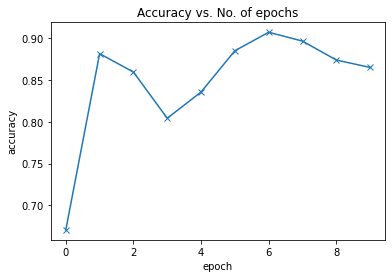

In [37]:
train_epochs(model, epochs=100, lr=0.001)
print('validation set:', evaluate(model, x_val, y_val))
plot_accuracies(metrics)

In [38]:
print('test set:', evaluate(model, x_test, y_test))

test set: {'loss': 0.3190191388130188, 'accuracy': 0.9089999794960022}
